## Preface

Я был слегка испуган библиотекой pyltr, так как она года 3 не обновлялась, и у меня закралось ощущение, что ей никто не пользуется

Поэтому я искал, что же такое есть +- готовое и по тегу **[learning-to-rank](https://github.com/topics/learning-to-rank)** только https://github.com/lyst/lightfm вызвала доверие.

light fm это библиотека для рекомендательных систем и вся её новизна это очередное гибридное разложение матрицы. В  статье авторы пишут, что для разряженных данных всё работает норм.

### Алгоритм

В библиотеке реализованы два подхода:
BPR: Bayesian Personalized Ranking from Implicit Feedback и Weighted Approximate-Rank Pairwise loss

BPR: агоритм выбирает случайный триплет (пользователь - объект - объект) и обновляет aпосториорное распределение: мол если для пользователя Андрей фильм Первый Мститель был на первом месте, то фильм Второй Сын будет на каком? Априорное распределнение обычно нормальное.

В результате получаются некие скрытые предпочтения пользователей к фильмам, которые потом раскладываются из матрицы.

warp loss отличается только отбором этих самых пар для обучения. Если в BPR, отбираются из условно нормального распределения куда у всех пар есть одинаковая вероятность попасть и повторные пары отбираются редко, то для WARP алгоритм ищет "неправильные пары"и обновляет веса только для них. Если веса пары Андрей Первый Мситель 0.87, а у Андрей Второй Сын 0.63, но первого мсителя Андрей оценил ниже, чем второго сына, то 0.87 немного убавится, а 0.63 подрастёт.

Это в натуральном виде pairwise алгоритм.

это заглушка, чтобы рок аук правильно считался

## Load libs

In [ ]:
!pip install lightfm
!pip install scikit-optimize

     |████████████████████████████████| 102kB 3.1MB/s 


In [ ]:
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.special import expit
import pickle
import csv
import copy
import itertools
from lightfm import LightFM
import lightfm.evaluation
import sys
from scipy.sparse import coo_matrix, find

### helpers.py 

from https://github.com/EthanRosenthal/rec-a-sketch 

In [ ]:
import scipy.sparse as sp
import numpy as np


def threshold_interactions_df(df, row_name, col_name, row_min, col_min):
    """Limit interactions df to minimum row and column interactions.
    Parameters
    ----------
    df : DataFrame
        DataFrame which contains a single row for each interaction between
        two entities. Typically, the two entities are a user and an item.
    row_name : str
        Name of column in df which corresponds to the eventual row in the
        interactions matrix.
    col_name : str
        Name of column in df which corresponds to the eventual column in the
        interactions matrix.
    row_min : int
        Minimum number of interactions that the row entity has had with
        distinct column entities.
    col_min : int
        Minimum number of interactions that the column entity has had with
        distinct row entities.
    Returns
    -------
    df : DataFrame
        Thresholded version of the input df. Order of rows is not preserved.
    Examples
    --------
    df looks like:
    user_id | item_id
    =================
      1001  |  2002
      1001  |  2004
      1002  |  2002
    thus, row_name = 'user_id', and col_name = 'item_id'
    If we were to set row_min = 2 and col_min = 1, then the returned df would
    look like
    user_id | item_id
    =================
      1001  |  2002
      1001  |  2004
    """

    n_rows = df[row_name].unique().shape[0]
    n_cols = df[col_name].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_rows*n_cols) * 100
    print('Starting interactions info')
    print('Number of rows: {}'.format(n_rows))
    print('Number of cols: {}'.format(n_cols))
    print('Sparsity: {:4.3f}%'.format(sparsity))

    done = False
    while not done:
        starting_shape = df.shape[0]
        col_counts = df.groupby(row_name)[col_name].count()
        df = df[~df[row_name].isin(col_counts[col_counts < col_min].index.tolist())]
        row_counts = df.groupby(col_name)[row_name].count()
        df = df[~df[col_name].isin(row_counts[row_counts < row_min].index.tolist())]
        ending_shape = df.shape[0]
        if starting_shape == ending_shape:
            done = True

    n_rows = df[row_name].unique().shape[0]
    n_cols = df[col_name].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_rows*n_cols) * 100
    print('Ending interactions info')
    print('Number of rows: {}'.format(n_rows))
    print('Number of columns: {}'.format(n_cols))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df


def get_df_matrix_mappings(df, row_name, col_name):
    """Map entities in interactions df to row and column indices
    Parameters
    ----------
    df : DataFrame
        Interactions DataFrame.
    row_name : str
        Name of column in df which contains row entities.
    col_name : str
        Name of column in df which contains column entities.
    Returns
    -------
    rid_to_idx : dict
        Maps row ID's to the row index in the eventual interactions matrix.
    idx_to_rid : dict
        Reverse of rid_to_idx. Maps row index to row ID.
    cid_to_idx : dict
        Same as rid_to_idx but for column ID's
    idx_to_cid : dict
    """


    # Create mappings
    rid_to_idx = {}
    idx_to_rid = {}
    for (idx, rid) in enumerate(df[row_name].unique().tolist()):
        rid_to_idx[rid] = idx
        idx_to_rid[idx] = rid

    cid_to_idx = {}
    idx_to_cid = {}
    for (idx, cid) in enumerate(df[col_name].unique().tolist()):
        cid_to_idx[cid] = idx
        idx_to_cid[idx] = cid

    return rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid


def df_to_matrix(df, row_name, col_name):
    """Take interactions dataframe and convert to a sparse matrix
    Parameters
    ----------
    df : DataFrame
    row_name : str
    col_name : str
    Returns
    -------
    interactions : sparse csr matrix
    rid_to_idx : dict
    idx_to_rid : dict
    cid_to_idx : dict
    idx_to_cid : dict
    """

    rid_to_idx, idx_to_rid,\
        cid_to_idx, idx_to_cid = get_df_matrix_mappings(df,
                                                        row_name,
                                                        col_name)

    def map_ids(row, mapper):
        return mapper[row]

    I = df[row_name].apply(map_ids, args=[rid_to_idx]).to_numpy()
    J = df[col_name].apply(map_ids, args=[cid_to_idx]).to_numpy()
    V = np.ones(I.shape[0])
    interactions = sp.coo_matrix((V, (I, J)), dtype=np.float64)
    interactions = interactions.tocsr()
    return interactions, rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid


def train_test_split(interactions, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    Params
    ------
    interactions : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all
        users are considered.
    """
    # Note: likely not the fastest way to do things below.
    train = interactions.copy().tocoo()
    test = sp.lil_matrix(train.shape)

    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0],
                replace=False,
                size=np.int64(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*split_count, fraction))
            raise
    else:
        user_index = range(train.shape[0])

    train = train.tolil()

    for user in user_index:
        test_interactions = np.random.choice(interactions.getrow(user).indices,
                                        size=split_count,
                                        replace=False)
        train[user, test_interactions] = 0.
        # These are just 1.0 right now
        test[user, test_interactions] = interactions[user, test_interactions]


    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif (isinstance(r, float)
              or isinstance(r, np.float32)
              or isinstance(r, np.float64)):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

def patk_learning_curve(model, train, test, eval_train,
                        iterarray, user_features=None,
                        item_features=None, k=5,
                        **fit_params):
    old_epoch = 0
    train_patk = []
    test_patk = []
    headers = ['Epoch', 'train p@5', 'test p@5']
    print_log(headers, header=True)
    for epoch in iterarray:
        more = epoch - old_epoch
        model.fit_partial(train, user_features=user_features,
                          item_features=item_features,
                          epochs=more, **fit_params)
        this_test = lightfm.evaluation.precision_at_k(model, test, train_interactions=None, k=k)
        this_train = lightfm.evaluation.precision_at_k(model, eval_train, train_interactions=None, k=k)

        train_patk.append(np.mean(this_train))
        test_patk.append(np.mean(this_test))
        row = [epoch, train_patk[-1], test_patk[-1]]
        print_log(row)
    return model, train_patk, test_patk

def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('p@{}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

### Данные

Как я понял, что-угодно, что можно пихнуть в разряженную матрицу вида user-item подходит для алгоритма. Возьму данные, с которыми работаю по проекту и всеми правдами и неправдами превращу их в требуемый формат.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS/sf_4_2019.csv')
data = data[["taxon_name", "user_id", "id"]]
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = threshold_interactions_df(data, 'user_id', 'taxon_name', 5, 5)

Starting interactions info
Number of rows: 3136
Number of cols: 3312
Sparsity: 0.833%
Ending interactions info
Number of rows: 2409
Number of columns: 2404
Sparsity: 1.399%


оставим только ту живность которая встретилась больше 5 раз и пользователей, которые отметили как минимум 5 живностей

In [ ]:
scans, uid_to_idx, idx_to_uid,\
mid_to_idx, idx_to_mid = df_to_matrix(data, 'user_id', 'taxon_name')

In [ ]:
train, test, user_index = train_test_split(scans, 5, fraction=0.2)

Разобьём матрицу на обучающую и на тестовую, причём будем просто вытаскивать куски данных, так как модель не умеет предсказывать для совсем новых пользователей

In [ ]:
eval_train = train.copy()
non_eval_users = list(set(range(train.shape[0])) - set(user_index))

eval_train = eval_train.tolil()
for u in non_eval_users:
    eval_train[u, :] = 0.0
eval_train = eval_train.tocsr()

## base example short
why warp, and not bpr

In [ ]:
alpha = 1e-05
epochs = 30
num_components = 64

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=1)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())

## AUC

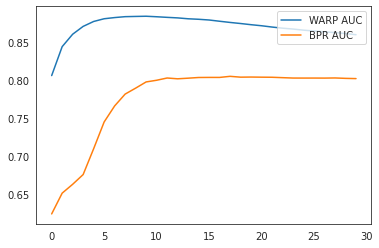

In [ ]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

In [ ]:
train_auc = auc_score(warp_model, train).mean()
test_auc = auc_score(warp_model, test).mean()

print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 1.00, test 0.85.


## FULL Model test

In [ ]:
alpha = 1e-05
epochs = 50
num_components = 20


model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    # max_sampled=100,
                    # user_alpha=alpha,
                    # item_alpha=alpha,
                    random_state=42)
# Initialize model.
model.fit(train, epochs=0);

iterarray = range(10, 60, 10)

model, train_patk, test_patk = patk_learning_curve(
    model, train, test, eval_train, iterarray, k=5, **{'num_threads': 4}
)

+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     10     |  0.32183   |  0.06237   |
+------------+------------+------------+
|     20     |  0.38420   |  0.06071   |
+------------+------------+------------+
|     30     |  0.40790   |  0.05780   |
+------------+------------+------------+
|     40     |  0.41622   |  0.05114   |
+------------+------------+------------+
|     50     |  0.41289   |  0.04782   |
+------------+------------+------------+


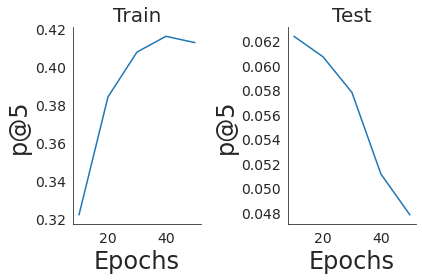

In [ ]:
# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout();

### ROC AUC

In [ ]:
train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.98, test 0.86.


### Fake MAP@5

In [ ]:
ranks = model.predict_rank(train)
ranks.data = np.less(ranks.data, 4, ranks.data)
precision = np.squeeze(np.array(ranks.sum(axis=1))) / 4
precision = precision[train.getnnz(axis=1) > 0]
train_map = precision.mean()

ranks = model.predict_rank(test)
ranks.data = np.less(ranks.data, 4, ranks.data)
precision = np.squeeze(np.array(ranks.sum(axis=1))) / 4
precision = precision[test.getnnz(axis=1) > 0]
test_map = precision.mean()


print('MAP@4: train %.2f, test %.2f.' % (train_map, test_map))

MAP@4: train 0.39, test 0.05.


## TUNING

c помощью forest_minimize попробуем слегка улучшить модель, оптимизируя по P@k

In [ ]:
from skopt import forest_minimize

In [ ]:
def objective(params):
    # unpack
    epochs, learning_rate,\
    no_components, alpha = params
    
    user_alpha = alpha
    item_alpha = alpha
    model = LightFM(loss='warp',
                    random_state=42,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
              num_threads=4, verbose=True)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                              train_interactions=None,
                                              k=5, num_threads=4)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Handle some weird numerical shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

In [ ]:
space = [(1, 50), # epochs
         (10**-4, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-6, 10**-1, 'log-uniform'), # alpha
        ]

res_fm = forest_minimize(objective, space, n_calls=250,
                     random_state=0,
                     verbose=True)

Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.


Epoch:   2%|▎         | 1/40 [00:00<00:04,  8.74it/s]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.4629
Function value obtained: -0.0017
Current minimum: -0.0017
Iteration No: 2 started. Evaluating function at random point.


Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.7737
Function value obtained: -0.0453
Current minimum: -0.0453
Iteration No: 3 started. Evaluating function at random point.


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.0354
Function value obtained: -0.0004
Current minimum: -0.0453
Iteration No: 4 started. Evaluating function at random point.


Epoch:   0%|          | 0/18 [00:00<?, ?it/s]

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8629
Function value obtained: -0.0104
Current minimum: -0.0453
Iteration No: 5 started. Evaluating function at random point.


Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.9259
Function value obtained: -0.0033
Current minimum: -0.0453
Iteration No: 6 started. Evaluating function at random point.


Epoch:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 5.5837
Function value obtained: -0.0412
Current minimum: -0.0453
Iteration No: 7 started. Evaluating function at random point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 9.5654
Function value obtained: -0.0541
Current minimum: -0.0541
Iteration No: 8 started. Evaluating function at random point.


Epoch:  10%|█         | 1/10 [00:00<00:01,  6.88it/s]

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 9.5965
Function value obtained: -0.0661
Current minimum: -0.0661
Iteration No: 9 started. Evaluating function at random point.


Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 1.5633
Function value obtained: -0.0470
Current minimum: -0.0661
Iteration No: 10 started. Evaluating function at random point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 8.6007
Function value obtained: -0.0424
Current minimum: -0.0661
Iteration No: 11 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 7.4808
Function value obtained: -0.0669
Current minimum: -0.0669
Iteration No: 12 started. Searching for the next optimal point.


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 10.1744
Function value obtained: -0.0000
Current minimum: -0.0669
Iteration No: 13 started. Searching for the next optimal point.


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 6.3152
Function value obtained: -0.0644
Current minimum: -0.0669
Iteration No: 14 started. Searching for the next optimal point.


Epoch:   0%|          | 0/31 [00:00<?, ?it/s]

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 6.3629
Function value obtained: -0.0499
Current minimum: -0.0669
Iteration No: 15 started. Searching for the next optimal point.


Epoch:   0%|          | 0/28 [00:00<?, ?it/s]

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 14.7662
Function value obtained: -0.0545
Current minimum: -0.0669
Iteration No: 16 started. Searching for the next optimal point.


Epoch:   0%|          | 0/18 [00:00<?, ?it/s]

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 13.5932
Function value obtained: -0.0012
Current minimum: -0.0669
Iteration No: 17 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 8.9674
Function value obtained: -0.0474
Current minimum: -0.0669
Iteration No: 18 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.1215
Function value obtained: -0.0711
Current minimum: -0.0711
Iteration No: 19 started. Searching for the next optimal point.


Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 7.2163
Function value obtained: -0.0665
Current minimum: -0.0711
Iteration No: 20 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 8.5898
Function value obtained: -0.0229
Current minimum: -0.0711
Iteration No: 21 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 9.1831
Function value obtained: -0.0632
Current minimum: -0.0711
Iteration No: 22 started. Searching for the next optimal point.


Epoch:   0%|          | 0/32 [00:00<?, ?it/s]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 6.9661
Function value obtained: -0.0682
Current minimum: -0.0711
Iteration No: 23 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 11.6400
Function value obtained: -0.0640
Current minimum: -0.0711
Iteration No: 24 started. Searching for the next optimal point.


Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 6.0318
Function value obtained: -0.0748
Current minimum: -0.0748
Iteration No: 25 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 6.1211
Function value obtained: -0.0674
Current minimum: -0.0748
Iteration No: 26 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 5.8314
Function value obtained: -0.0545
Current minimum: -0.0748
Iteration No: 27 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 6.9473
Function value obtained: -0.0046
Current minimum: -0.0748
Iteration No: 28 started. Searching for the next optimal point.


Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 6.7948
Function value obtained: -0.0661
Current minimum: -0.0748
Iteration No: 29 started. Searching for the next optimal point.


Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 6.6270
Function value obtained: -0.0428
Current minimum: -0.0748
Iteration No: 30 started. Searching for the next optimal point.


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 15.2005
Function value obtained: -0.0632
Current minimum: -0.0748
Iteration No: 31 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/46 [00:00<00:06,  6.97it/s]

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 2.4900
Function value obtained: -0.0557
Current minimum: -0.0748
Iteration No: 32 started. Searching for the next optimal point.


Epoch:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 6.5287
Function value obtained: -0.0640
Current minimum: -0.0748
Iteration No: 33 started. Searching for the next optimal point.


Epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 6.0373
Function value obtained: -0.0582
Current minimum: -0.0748
Iteration No: 34 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 10.9827
Function value obtained: -0.0545
Current minimum: -0.0748
Iteration No: 35 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 7.6930
Function value obtained: -0.0453
Current minimum: -0.0748
Iteration No: 36 started. Searching for the next optimal point.


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 4.6338
Function value obtained: -0.0595
Current minimum: -0.0748
Iteration No: 37 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 8.4828
Function value obtained: -0.0657
Current minimum: -0.0748
Iteration No: 38 started. Searching for the next optimal point.


Epoch:   0%|          | 0/44 [00:00<?, ?it/s]

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 12.6931
Function value obtained: -0.0640
Current minimum: -0.0748
Iteration No: 39 started. Searching for the next optimal point.


Epoch:   0%|          | 0/44 [00:00<?, ?it/s]

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 13.3211
Function value obtained: -0.0008
Current minimum: -0.0748
Iteration No: 40 started. Searching for the next optimal point.


Epoch:   0%|          | 0/36 [00:00<?, ?it/s]

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 10.9773
Function value obtained: -0.0395
Current minimum: -0.0748
Iteration No: 41 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 10.7916
Function value obtained: -0.0611
Current minimum: -0.0748
Iteration No: 42 started. Searching for the next optimal point.


Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 14.7740
Function value obtained: -0.0699
Current minimum: -0.0748
Iteration No: 43 started. Searching for the next optimal point.


Epoch:   0%|          | 0/45 [00:00<?, ?it/s]

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 14.6509
Function value obtained: -0.0561
Current minimum: -0.0748
Iteration No: 44 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 15.4964
Function value obtained: -0.0557
Current minimum: -0.0748
Iteration No: 45 started. Searching for the next optimal point.


Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 25.0051
Function value obtained: -0.0004
Current minimum: -0.0748
Iteration No: 46 started. Searching for the next optimal point.


Epoch:   0%|          | 0/43 [00:00<?, ?it/s]

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 11.2693
Function value obtained: -0.0661
Current minimum: -0.0748
Iteration No: 47 started. Searching for the next optimal point.


Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 20.4764
Function value obtained: -0.0636
Current minimum: -0.0748
Iteration No: 48 started. Searching for the next optimal point.


Epoch:   0%|          | 0/42 [00:00<?, ?it/s]

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 18.8185
Function value obtained: -0.0661
Current minimum: -0.0748
Iteration No: 49 started. Searching for the next optimal point.


Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 20.5496
Function value obtained: -0.0607
Current minimum: -0.0748
Iteration No: 50 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 22.5928
Function value obtained: -0.0640
Current minimum: -0.0748
Iteration No: 51 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 20.3686
Function value obtained: -0.0000
Current minimum: -0.0748
Iteration No: 52 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 22.3738
Function value obtained: -0.0603
Current minimum: -0.0748
Iteration No: 53 started. Searching for the next optimal point.


Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 21.3419
Function value obtained: -0.0640
Current minimum: -0.0748
Iteration No: 54 started. Searching for the next optimal point.


Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 18.3604
Function value obtained: -0.0445
Current minimum: -0.0748
Iteration No: 55 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 11.0860
Function value obtained: -0.0549
Current minimum: -0.0748
Iteration No: 56 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 24.2022
Function value obtained: -0.0640
Current minimum: -0.0748
Iteration No: 57 started. Searching for the next optimal point.


Epoch:   0%|          | 0/43 [00:00<?, ?it/s]

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 14.3267
Function value obtained: -0.0582
Current minimum: -0.0748
Iteration No: 58 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 21.2084
Function value obtained: -0.0611
Current minimum: -0.0748
Iteration No: 59 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 19.7897
Function value obtained: -0.0258
Current minimum: -0.0748
Iteration No: 60 started. Searching for the next optimal point.


Epoch:   0%|          | 0/22 [00:00<?, ?it/s]

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 5.4789
Function value obtained: -0.0428
Current minimum: -0.0748
Iteration No: 61 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 7.0539
Function value obtained: -0.0387
Current minimum: -0.0748
Iteration No: 62 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 21.9530
Function value obtained: -0.0249
Current minimum: -0.0748
Iteration No: 63 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 24.0744
Function value obtained: -0.0628
Current minimum: -0.0748
Iteration No: 64 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 21.8836
Function value obtained: -0.0661
Current minimum: -0.0748
Iteration No: 65 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 23.9991
Function value obtained: -0.0615
Current minimum: -0.0748
Iteration No: 66 started. Searching for the next optimal point.


Epoch:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 20.5560
Function value obtained: -0.0407
Current minimum: -0.0748
Iteration No: 67 started. Searching for the next optimal point.


Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 4.0277
Function value obtained: -0.0416
Current minimum: -0.0748
Iteration No: 68 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 9.5451
Function value obtained: -0.0457
Current minimum: -0.0748
Iteration No: 69 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 11.0210
Function value obtained: -0.0678
Current minimum: -0.0748
Iteration No: 70 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 18.1423
Function value obtained: -0.0432
Current minimum: -0.0748
Iteration No: 71 started. Searching for the next optimal point.


Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 23.6563
Function value obtained: -0.0690
Current minimum: -0.0748
Iteration No: 72 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 20.3523
Function value obtained: -0.0158
Current minimum: -0.0748
Iteration No: 73 started. Searching for the next optimal point.


Epoch:   0%|          | 0/45 [00:00<?, ?it/s]

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 14.3178
Function value obtained: -0.0195
Current minimum: -0.0748
Iteration No: 74 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/49 [00:00<00:03, 13.60it/s]

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 22.4384
Function value obtained: -0.0299
Current minimum: -0.0748
Iteration No: 75 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/50 [00:00<00:03, 13.87it/s]

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 4.0412
Function value obtained: -0.0744
Current minimum: -0.0748
Iteration No: 76 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/46 [00:00<00:06,  6.96it/s]

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 3.8975
Function value obtained: -0.0657
Current minimum: -0.0748
Iteration No: 77 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/46 [00:00<00:06,  6.88it/s]

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 6.3607
Function value obtained: -0.0212
Current minimum: -0.0748
Iteration No: 78 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 7.0448
Function value obtained: -0.0387
Current minimum: -0.0748
Iteration No: 79 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 9.9695
Function value obtained: -0.0644
Current minimum: -0.0748
Iteration No: 80 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 17.8497
Function value obtained: -0.0628
Current minimum: -0.0748
Iteration No: 81 started. Searching for the next optimal point.


Epoch:   0%|          | 0/43 [00:00<?, ?it/s]

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 21.0610
Function value obtained: -0.0607
Current minimum: -0.0748
Iteration No: 82 started. Searching for the next optimal point.


Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 11.7934
Function value obtained: -0.0649
Current minimum: -0.0748
Iteration No: 83 started. Searching for the next optimal point.


Epoch:   0%|          | 0/44 [00:00<?, ?it/s]

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 21.2249
Function value obtained: -0.0561
Current minimum: -0.0748
Iteration No: 84 started. Searching for the next optimal point.


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 9.5801
Function value obtained: -0.0582
Current minimum: -0.0748
Iteration No: 85 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.6312
Function value obtained: -0.0528
Current minimum: -0.0748
Iteration No: 86 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/50 [00:00<00:05,  9.22it/s]

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 22.7456
Function value obtained: -0.0603
Current minimum: -0.0748
Iteration No: 87 started. Searching for the next optimal point.


Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 5.8862
Function value obtained: -0.0054
Current minimum: -0.0748
Iteration No: 88 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/50 [00:00<00:07,  6.98it/s]

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 9.7211
Function value obtained: -0.0565
Current minimum: -0.0748
Iteration No: 89 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/48 [00:00<00:06,  7.42it/s]

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 7.8786
Function value obtained: -0.0590
Current minimum: -0.0748
Iteration No: 90 started. Searching for the next optimal point.


Epoch:   8%|▊         | 2/25 [00:00<00:01, 14.33it/s]

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 7.0166
Function value obtained: -0.0624
Current minimum: -0.0748
Iteration No: 91 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/50 [00:00<00:06,  7.01it/s]

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 2.1552
Function value obtained: -0.0586
Current minimum: -0.0748
Iteration No: 92 started. Searching for the next optimal point.


Epoch:   6%|▌         | 2/36 [00:00<00:02, 14.44it/s]

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 7.3475
Function value obtained: -0.0719
Current minimum: -0.0748
Iteration No: 93 started. Searching for the next optimal point.


Epoch:   5%|▌         | 2/37 [00:00<00:02, 13.12it/s]

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 2.9424
Function value obtained: -0.0599
Current minimum: -0.0748
Iteration No: 94 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 3.0130
Function value obtained: -0.0316
Current minimum: -0.0748
Iteration No: 95 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 4.9611
Function value obtained: -0.0678
Current minimum: -0.0748
Iteration No: 96 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/48 [00:00<00:03, 14.47it/s]

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 23.2635
Function value obtained: -0.0595
Current minimum: -0.0748
Iteration No: 97 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/50 [00:00<00:05,  8.37it/s]

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 3.7173
Function value obtained: -0.0004
Current minimum: -0.0748
Iteration No: 98 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/49 [00:00<00:03, 13.67it/s]

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 6.2558
Function value obtained: -0.0682
Current minimum: -0.0748
Iteration No: 99 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 3.8381
Function value obtained: -0.0179
Current minimum: -0.0748
Iteration No: 100 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/49 [00:00<00:05,  8.94it/s]

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 23.8983
Function value obtained: -0.0553
Current minimum: -0.0748
Iteration No: 101 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/49 [00:00<00:02, 15.86it/s]

Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 6.0246
Function value obtained: -0.0711
Current minimum: -0.0748
Iteration No: 102 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/50 [00:00<00:08,  5.61it/s]

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 3.3608
Function value obtained: -0.0632
Current minimum: -0.0748
Iteration No: 103 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/46 [00:00<00:02, 15.13it/s]

Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 9.3280
Function value obtained: -0.0482
Current minimum: -0.0748
Iteration No: 104 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/48 [00:00<00:05,  8.59it/s]

Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 3.2706
Function value obtained: -0.0657
Current minimum: -0.0748
Iteration No: 105 started. Searching for the next optimal point.


Epoch:  12%|█▎        | 2/16 [00:00<00:00, 14.18it/s]

Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 5.9102
Function value obtained: -0.0649
Current minimum: -0.0748
Iteration No: 106 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/49 [00:00<00:03, 11.97it/s]

Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 1.3710
Function value obtained: -0.0657
Current minimum: -0.0748
Iteration No: 107 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/48 [00:00<00:03, 11.58it/s]

Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 4.1758
Function value obtained: -0.0474
Current minimum: -0.0748
Iteration No: 108 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/46 [00:00<00:03, 14.33it/s]

Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 4.2709
Function value obtained: -0.0686
Current minimum: -0.0748
Iteration No: 109 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/49 [00:00<00:03, 11.94it/s]

Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 3.5509
Function value obtained: -0.0649
Current minimum: -0.0748
Iteration No: 110 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/47 [00:00<00:03, 12.20it/s]

Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 3.9797
Function value obtained: -0.0499
Current minimum: -0.0748
Iteration No: 111 started. Searching for the next optimal point.


Epoch:   5%|▍         | 2/43 [00:00<00:02, 14.61it/s]

Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 4.0921
Function value obtained: -0.0707
Current minimum: -0.0748
Iteration No: 112 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/48 [00:00<00:03, 12.26it/s]

Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 3.0694
Function value obtained: -0.0669
Current minimum: -0.0748
Iteration No: 113 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/48 [00:00<00:03, 15.33it/s]

Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 3.7611
Function value obtained: -0.0607
Current minimum: -0.0748
Iteration No: 114 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/47 [00:00<00:03, 12.40it/s]

Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 3.3635
Function value obtained: -0.0632
Current minimum: -0.0748
Iteration No: 115 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/50 [00:00<00:04, 11.47it/s]

Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 3.9112
Function value obtained: -0.0620
Current minimum: -0.0748
Iteration No: 116 started. Searching for the next optimal point.


Epoch:  12%|█▏        | 2/17 [00:00<00:01, 11.71it/s]

Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 4.7022
Function value obtained: -0.0004
Current minimum: -0.0748
Iteration No: 117 started. Searching for the next optimal point.


Epoch:   5%|▍         | 2/44 [00:00<00:02, 14.05it/s]

Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 1.7946
Function value obtained: -0.0366
Current minimum: -0.0748
Iteration No: 118 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/49 [00:00<00:04, 10.51it/s]

Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 3.6028
Function value obtained: -0.0620
Current minimum: -0.0748
Iteration No: 119 started. Searching for the next optimal point.


Epoch:   5%|▍         | 2/43 [00:00<00:03, 12.54it/s]

Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 5.4128
Function value obtained: -0.0495
Current minimum: -0.0748
Iteration No: 120 started. Searching for the next optimal point.


Epoch:   6%|▌         | 2/33 [00:00<00:01, 15.87it/s]

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 3.8043
Function value obtained: -0.0541
Current minimum: -0.0748
Iteration No: 121 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/50 [00:00<00:03, 12.16it/s]

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 2.3820
Function value obtained: -0.0308
Current minimum: -0.0748
Iteration No: 122 started. Searching for the next optimal point.


Epoch:  11%|█         | 2/18 [00:00<00:01, 11.07it/s]

Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 4.5645
Function value obtained: -0.0470
Current minimum: -0.0748
Iteration No: 123 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.0172
Function value obtained: -0.0607
Current minimum: -0.0748
Iteration No: 124 started. Searching for the next optimal point.


Epoch:   7%|▋         | 2/30 [00:00<00:01, 14.73it/s]

Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 8.1286
Function value obtained: -0.0728
Current minimum: -0.0748
Iteration No: 125 started. Searching for the next optimal point.


Epoch:   0%|          | 0/28 [00:00<?, ?it/s]

Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.3820
Function value obtained: -0.0649
Current minimum: -0.0748
Iteration No: 126 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/45 [00:00<00:06,  7.11it/s]

Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 12.3946
Function value obtained: -0.0462
Current minimum: -0.0748
Iteration No: 127 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/49 [00:00<00:05,  8.09it/s]

Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 6.3257
Function value obtained: -0.0595
Current minimum: -0.0748
Iteration No: 128 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/44 [00:00<00:05,  7.70it/s]

Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 6.4556
Function value obtained: -0.0632
Current minimum: -0.0748
Iteration No: 129 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/50 [00:00<00:06,  7.35it/s]

Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 5.8964
Function value obtained: -0.0428
Current minimum: -0.0748
Iteration No: 130 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/48 [00:00<00:03, 11.67it/s]

Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 7.0078
Function value obtained: -0.0528
Current minimum: -0.0748
Iteration No: 131 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/47 [00:00<00:03, 14.71it/s]

Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 4.5402
Function value obtained: -0.0541
Current minimum: -0.0748
Iteration No: 132 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/50 [00:00<00:05,  9.38it/s]

Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 3.4912
Function value obtained: -0.0391
Current minimum: -0.0748
Iteration No: 133 started. Searching for the next optimal point.


Epoch:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 5.8024
Function value obtained: -0.0640
Current minimum: -0.0748
Iteration No: 134 started. Searching for the next optimal point.


Epoch:   7%|▋         | 2/28 [00:00<00:01, 14.64it/s]

Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 9.4575
Function value obtained: -0.0516
Current minimum: -0.0748
Iteration No: 135 started. Searching for the next optimal point.


Epoch:   0%|          | 0/42 [00:00<?, ?it/s]

Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 2.2083
Function value obtained: -0.0424
Current minimum: -0.0748
Iteration No: 136 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/50 [00:00<00:04, 11.48it/s]

Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 16.2427
Function value obtained: -0.0657
Current minimum: -0.0748
Iteration No: 137 started. Searching for the next optimal point.


Epoch:   0%|          | 0/44 [00:00<?, ?it/s]

Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 4.6988
Function value obtained: -0.0703
Current minimum: -0.0748
Iteration No: 138 started. Searching for the next optimal point.


Epoch:   0%|          | 0/23 [00:00<?, ?it/s]

Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 19.6028
Function value obtained: -0.0258
Current minimum: -0.0748
Iteration No: 139 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 9.0114
Function value obtained: -0.0557
Current minimum: -0.0748
Iteration No: 140 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 8.0055
Function value obtained: -0.0665
Current minimum: -0.0748
Iteration No: 141 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 7.6639
Function value obtained: -0.0703
Current minimum: -0.0748
Iteration No: 142 started. Searching for the next optimal point.


Epoch:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 8.1562
Function value obtained: -0.0661
Current minimum: -0.0748
Iteration No: 143 started. Searching for the next optimal point.


Epoch:   0%|          | 0/18 [00:00<?, ?it/s]

Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 7.2527
Function value obtained: -0.0590
Current minimum: -0.0748
Iteration No: 144 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 6.4976
Function value obtained: -0.0241
Current minimum: -0.0748
Iteration No: 145 started. Searching for the next optimal point.


Epoch:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 7.3443
Function value obtained: -0.0308
Current minimum: -0.0748
Iteration No: 146 started. Searching for the next optimal point.


Epoch:   0%|          | 0/22 [00:00<?, ?it/s]

Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 4.3428
Function value obtained: -0.0653
Current minimum: -0.0748
Iteration No: 147 started. Searching for the next optimal point.


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 6.8256
Function value obtained: -0.0653
Current minimum: -0.0748
Iteration No: 148 started. Searching for the next optimal point.


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 7.2359
Function value obtained: -0.0640
Current minimum: -0.0748
Iteration No: 149 started. Searching for the next optimal point.


Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 8.2623
Function value obtained: -0.0719
Current minimum: -0.0748
Iteration No: 150 started. Searching for the next optimal point.


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 6.4656
Function value obtained: -0.0678
Current minimum: -0.0748
Iteration No: 151 started. Searching for the next optimal point.


Epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 11.4067
Function value obtained: -0.0678
Current minimum: -0.0748
Iteration No: 152 started. Searching for the next optimal point.


Epoch:   0%|          | 0/22 [00:00<?, ?it/s]

Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 14.0537
Function value obtained: -0.0686
Current minimum: -0.0748
Iteration No: 153 started. Searching for the next optimal point.


Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 6.1883
Function value obtained: -0.0632
Current minimum: -0.0748
Iteration No: 154 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 5.8948
Function value obtained: -0.0503
Current minimum: -0.0748
Iteration No: 155 started. Searching for the next optimal point.


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 22.7834
Function value obtained: -0.0628
Current minimum: -0.0748
Iteration No: 156 started. Searching for the next optimal point.


Epoch:   3%|▎         | 1/29 [00:00<00:03,  8.97it/s]

Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 4.1327
Function value obtained: -0.0624
Current minimum: -0.0748
Iteration No: 157 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 3.2664
Function value obtained: -0.0333
Current minimum: -0.0748
Iteration No: 158 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 24.6202
Function value obtained: -0.0021
Current minimum: -0.0748
Iteration No: 159 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/50 [00:00<00:03, 15.00it/s]

Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 22.0552
Function value obtained: -0.0549
Current minimum: -0.0748
Iteration No: 160 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 3.6888
Function value obtained: -0.0699
Current minimum: -0.0748
Iteration No: 161 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 24.2580
Function value obtained: -0.0678
Current minimum: -0.0748
Iteration No: 162 started. Searching for the next optimal point.


Epoch:   0%|          | 0/45 [00:00<?, ?it/s]

Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 23.7010
Function value obtained: -0.0719
Current minimum: -0.0748
Iteration No: 163 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 21.7075
Function value obtained: -0.0707
Current minimum: -0.0748
Iteration No: 164 started. Searching for the next optimal point.


Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 22.7325
Function value obtained: -0.0686
Current minimum: -0.0748
Iteration No: 165 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 21.7086
Function value obtained: -0.0590
Current minimum: -0.0748
Iteration No: 166 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 24.4226
Function value obtained: -0.0549
Current minimum: -0.0748
Iteration No: 167 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 23.4522
Function value obtained: -0.0412
Current minimum: -0.0748
Iteration No: 168 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 24.0044
Function value obtained: -0.0628
Current minimum: -0.0748
Iteration No: 169 started. Searching for the next optimal point.


Epoch:   0%|          | 0/43 [00:00<?, ?it/s]

Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 21.4983
Function value obtained: -0.0320
Current minimum: -0.0748
Iteration No: 170 started. Searching for the next optimal point.


Epoch:   0%|          | 0/42 [00:00<?, ?it/s]

Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 15.8889
Function value obtained: -0.0008
Current minimum: -0.0748
Iteration No: 171 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/49 [00:00<00:03, 14.51it/s]

Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 18.1493
Function value obtained: -0.0503
Current minimum: -0.0748
Iteration No: 172 started. Searching for the next optimal point.


Epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 3.8112
Function value obtained: -0.0699
Current minimum: -0.0748
Iteration No: 173 started. Searching for the next optimal point.


Epoch:   0%|          | 0/27 [00:00<?, ?it/s]

Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 12.8526
Function value obtained: -0.0262
Current minimum: -0.0748
Iteration No: 174 started. Searching for the next optimal point.


Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 13.0658
Function value obtained: -0.0607
Current minimum: -0.0748
Iteration No: 175 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/50 [00:00<00:03, 14.57it/s]

Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 21.8586
Function value obtained: -0.0595
Current minimum: -0.0748
Iteration No: 176 started. Searching for the next optimal point.


Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 3.7201
Function value obtained: -0.0424
Current minimum: -0.0748
Iteration No: 177 started. Searching for the next optimal point.


Epoch:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 11.8152
Function value obtained: -0.0640
Current minimum: -0.0748
Iteration No: 178 started. Searching for the next optimal point.


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 5.3834
Function value obtained: -0.0200
Current minimum: -0.0748
Iteration No: 179 started. Searching for the next optimal point.


Epoch:   0%|          | 0/44 [00:00<?, ?it/s]

Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 1.0543
Function value obtained: -0.0441
Current minimum: -0.0748
Iteration No: 180 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 21.9852
Function value obtained: -0.0649
Current minimum: -0.0748
Iteration No: 181 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 8.8106
Function value obtained: -0.0615
Current minimum: -0.0748
Iteration No: 182 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 22.5713
Function value obtained: -0.0657
Current minimum: -0.0748
Iteration No: 183 started. Searching for the next optimal point.


Epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 12.1702
Function value obtained: -0.0553
Current minimum: -0.0748
Iteration No: 184 started. Searching for the next optimal point.


Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 21.2374
Function value obtained: -0.0004
Current minimum: -0.0748
Iteration No: 185 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 23.1750
Function value obtained: -0.0511
Current minimum: -0.0748
Iteration No: 186 started. Searching for the next optimal point.


Epoch:   0%|          | 0/42 [00:00<?, ?it/s]

Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 10.5763
Function value obtained: -0.0412
Current minimum: -0.0748
Iteration No: 187 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 19.9891
Function value obtained: -0.0553
Current minimum: -0.0748
Iteration No: 188 started. Searching for the next optimal point.


Epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 24.0942
Function value obtained: -0.0607
Current minimum: -0.0748
Iteration No: 189 started. Searching for the next optimal point.


Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 19.4158
Function value obtained: -0.0678
Current minimum: -0.0748
Iteration No: 190 started. Searching for the next optimal point.


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 6.2756
Function value obtained: -0.0624
Current minimum: -0.0748
Iteration No: 191 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 9.5411
Function value obtained: -0.0495
Current minimum: -0.0748
Iteration No: 192 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 22.7433
Function value obtained: -0.0320
Current minimum: -0.0748
Iteration No: 193 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/49 [00:00<00:03, 11.96it/s]

Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 21.6700
Function value obtained: -0.0462
Current minimum: -0.0748
Iteration No: 194 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 4.3683
Function value obtained: -0.0678
Current minimum: -0.0748
Iteration No: 195 started. Searching for the next optimal point.


Epoch:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 8.4485
Function value obtained: -0.0062
Current minimum: -0.0748
Iteration No: 196 started. Searching for the next optimal point.


Epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 8.8825
Function value obtained: -0.0595
Current minimum: -0.0748
Iteration No: 197 started. Searching for the next optimal point.


Epoch:   0%|          | 0/28 [00:00<?, ?it/s]

Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 19.0780
Function value obtained: -0.0407
Current minimum: -0.0748
Iteration No: 198 started. Searching for the next optimal point.


Epoch:   0%|          | 0/11 [00:00<?, ?it/s]

Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 14.2491
Function value obtained: -0.0565
Current minimum: -0.0748
Iteration No: 199 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/50 [00:00<00:03, 12.14it/s]

Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 6.0620
Function value obtained: -0.0640
Current minimum: -0.0748
Iteration No: 200 started. Searching for the next optimal point.


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 4.4858
Function value obtained: -0.0578
Current minimum: -0.0748
Iteration No: 201 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/49 [00:00<00:02, 15.71it/s]

Iteration No: 201 ended. Search finished for the next optimal point.
Time taken: 6.4560
Function value obtained: -0.0225
Current minimum: -0.0748
Iteration No: 202 started. Searching for the next optimal point.


Epoch:   5%|▌         | 2/39 [00:00<00:02, 13.42it/s]

Iteration No: 202 ended. Search finished for the next optimal point.
Time taken: 3.5962
Function value obtained: -0.0657
Current minimum: -0.0748
Iteration No: 203 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/49 [00:00<00:07,  6.33it/s]

Iteration No: 203 ended. Search finished for the next optimal point.
Time taken: 3.4685
Function value obtained: -0.0412
Current minimum: -0.0748
Iteration No: 204 started. Searching for the next optimal point.


Epoch:   0%|          | 0/45 [00:00<?, ?it/s]

Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 7.8673
Function value obtained: -0.0516
Current minimum: -0.0748
Iteration No: 205 started. Searching for the next optimal point.


Epoch:   0%|          | 0/23 [00:00<?, ?it/s]

Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 4.6960
Function value obtained: -0.0570
Current minimum: -0.0748
Iteration No: 206 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 206 ended. Search finished for the next optimal point.
Time taken: 10.8189
Function value obtained: -0.0453
Current minimum: -0.0748
Iteration No: 207 started. Searching for the next optimal point.


Epoch:   0%|          | 0/17 [00:00<?, ?it/s]

Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 9.4836
Function value obtained: -0.0383
Current minimum: -0.0748
Iteration No: 208 started. Searching for the next optimal point.


Epoch:   6%|▌         | 1/17 [00:00<00:02,  6.29it/s]

Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 5.3781
Function value obtained: -0.0640
Current minimum: -0.0748
Iteration No: 209 started. Searching for the next optimal point.


Epoch:   0%|          | 0/45 [00:00<?, ?it/s]

Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 3.1648
Function value obtained: -0.0374
Current minimum: -0.0748
Iteration No: 210 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/45 [00:00<00:03, 11.82it/s]

Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 22.5483
Function value obtained: -0.0649
Current minimum: -0.0748
Iteration No: 211 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 4.1493
Function value obtained: -0.0104
Current minimum: -0.0748
Iteration No: 212 started. Searching for the next optimal point.


Epoch:   0%|          | 0/45 [00:00<?, ?it/s]

Iteration No: 212 ended. Search finished for the next optimal point.
Time taken: 23.8261
Function value obtained: -0.0100
Current minimum: -0.0748
Iteration No: 213 started. Searching for the next optimal point.


Epoch:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 21.9277
Function value obtained: -0.0470
Current minimum: -0.0748
Iteration No: 214 started. Searching for the next optimal point.


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 5.6320
Function value obtained: -0.0636
Current minimum: -0.0748
Iteration No: 215 started. Searching for the next optimal point.


Epoch:   0%|          | 0/18 [00:00<?, ?it/s]

Iteration No: 215 ended. Search finished for the next optimal point.
Time taken: 1.1724
Function value obtained: -0.0445
Current minimum: -0.0748
Iteration No: 216 started. Searching for the next optimal point.


Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 7.7676
Function value obtained: -0.0653
Current minimum: -0.0748
Iteration No: 217 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/49 [00:00<00:03, 14.33it/s]

Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 8.8234
Function value obtained: -0.0636
Current minimum: -0.0748
Iteration No: 218 started. Searching for the next optimal point.


Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 3.8861
Function value obtained: -0.0012
Current minimum: -0.0748
Iteration No: 219 started. Searching for the next optimal point.


Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 22.9666
Function value obtained: -0.0420
Current minimum: -0.0748
Iteration No: 220 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/49 [00:00<00:06,  7.21it/s]

Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 21.2575
Function value obtained: -0.0146
Current minimum: -0.0748
Iteration No: 221 started. Searching for the next optimal point.


Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 6.9199
Function value obtained: -0.0432
Current minimum: -0.0748
Iteration No: 222 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 222 ended. Search finished for the next optimal point.
Time taken: 20.0955
Function value obtained: -0.0661
Current minimum: -0.0748
Iteration No: 223 started. Searching for the next optimal point.


Epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Iteration No: 223 ended. Search finished for the next optimal point.
Time taken: 10.2698
Function value obtained: -0.0653
Current minimum: -0.0748
Iteration No: 224 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/50 [00:00<00:03, 13.84it/s]

Iteration No: 224 ended. Search finished for the next optimal point.
Time taken: 20.4373
Function value obtained: -0.0528
Current minimum: -0.0748
Iteration No: 225 started. Searching for the next optimal point.


Epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration No: 225 ended. Search finished for the next optimal point.
Time taken: 4.0878
Function value obtained: -0.0636
Current minimum: -0.0748
Iteration No: 226 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 226 ended. Search finished for the next optimal point.
Time taken: 8.2383
Function value obtained: -0.0628
Current minimum: -0.0748
Iteration No: 227 started. Searching for the next optimal point.


Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Iteration No: 227 ended. Search finished for the next optimal point.
Time taken: 7.6507
Function value obtained: -0.0104
Current minimum: -0.0748
Iteration No: 228 started. Searching for the next optimal point.


Epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration No: 228 ended. Search finished for the next optimal point.
Time taken: 8.3593
Function value obtained: -0.0432
Current minimum: -0.0748
Iteration No: 229 started. Searching for the next optimal point.


Epoch:   5%|▍         | 2/44 [00:00<00:03, 12.30it/s]

Iteration No: 229 ended. Search finished for the next optimal point.
Time taken: 19.4098
Function value obtained: -0.0457
Current minimum: -0.0748
Iteration No: 230 started. Searching for the next optimal point.


Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Iteration No: 230 ended. Search finished for the next optimal point.
Time taken: 4.0812
Function value obtained: -0.0653
Current minimum: -0.0748
Iteration No: 231 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 231 ended. Search finished for the next optimal point.
Time taken: 12.2673
Function value obtained: -0.0037
Current minimum: -0.0748
Iteration No: 232 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 232 ended. Search finished for the next optimal point.
Time taken: 8.0493
Function value obtained: -0.0582
Current minimum: -0.0748
Iteration No: 233 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/48 [00:00<00:03, 13.42it/s]

Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 15.1187
Function value obtained: -0.0574
Current minimum: -0.0748
Iteration No: 234 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/46 [00:00<00:02, 15.61it/s]

Iteration No: 234 ended. Search finished for the next optimal point.
Time taken: 4.0606
Function value obtained: -0.0545
Current minimum: -0.0748
Iteration No: 235 started. Searching for the next optimal point.


Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Iteration No: 235 ended. Search finished for the next optimal point.
Time taken: 3.3313
Function value obtained: -0.0628
Current minimum: -0.0748
Iteration No: 236 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 236 ended. Search finished for the next optimal point.
Time taken: 9.4657
Function value obtained: -0.0137
Current minimum: -0.0748
Iteration No: 237 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 22.2303
Function value obtained: -0.0565
Current minimum: -0.0748
Iteration No: 238 started. Searching for the next optimal point.


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 7.5949
Function value obtained: -0.0387
Current minimum: -0.0748
Iteration No: 239 started. Searching for the next optimal point.


Epoch:   0%|          | 0/37 [00:00<?, ?it/s]

Iteration No: 239 ended. Search finished for the next optimal point.
Time taken: 8.4668
Function value obtained: -0.0699
Current minimum: -0.0748
Iteration No: 240 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/50 [00:00<00:03, 14.33it/s]

Iteration No: 240 ended. Search finished for the next optimal point.
Time taken: 10.1168
Function value obtained: -0.0661
Current minimum: -0.0748
Iteration No: 241 started. Searching for the next optimal point.


Epoch:   4%|▍         | 2/49 [00:00<00:03, 15.01it/s]

Iteration No: 241 ended. Search finished for the next optimal point.
Time taken: 3.7832
Function value obtained: -0.0690
Current minimum: -0.0748
Iteration No: 242 started. Searching for the next optimal point.


Epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration No: 242 ended. Search finished for the next optimal point.
Time taken: 3.6747
Function value obtained: -0.0349
Current minimum: -0.0748
Iteration No: 243 started. Searching for the next optimal point.


Epoch:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 9.5153
Function value obtained: -0.0586
Current minimum: -0.0748
Iteration No: 244 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 10.4293
Function value obtained: -0.0345
Current minimum: -0.0748
Iteration No: 245 started. Searching for the next optimal point.


Epoch:   0%|          | 0/45 [00:00<?, ?it/s]

Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 24.1549
Function value obtained: -0.0536
Current minimum: -0.0748
Iteration No: 246 started. Searching for the next optimal point.


Epoch:   2%|▏         | 1/50 [00:00<00:07,  6.72it/s]

Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 22.3454
Function value obtained: -0.0532
Current minimum: -0.0748
Iteration No: 247 started. Searching for the next optimal point.


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration No: 247 ended. Search finished for the next optimal point.
Time taken: 7.7218
Function value obtained: -0.0353
Current minimum: -0.0748
Iteration No: 248 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 6.5467
Function value obtained: -0.0270
Current minimum: -0.0748
Iteration No: 249 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 12.9841
Function value obtained: -0.0532
Current minimum: -0.0748
Iteration No: 250 started. Searching for the next optimal point.


Epoch: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 25.1733
Function value obtained: -0.0403
Current minimum: -0.0748


In [ ]:
print('Maximimum p@5 found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'alpha']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))

Maximimum p@5 found: 0.07484
Optimal parameters:
epochs: 20
learning_rate: 0.060884281974219585
no_components: 110
alpha: 0.0010405166011076676


тюнинг поднял точность с 6 до 7, что совсем не стоили 30 минут ожидания, хотя если брать больше эпох, то может что-нибудь и вышло б

### Recomendation for user

In [ ]:
def sample_recommendation(model, data, idx_to_mid, user_id):


    n_users, n_items = train.shape


    if user_id >= 0:

        df_inx = pd.DataFrame(list(idx_to_mid.items()),columns = ['id','taxon']) 
        df_inx[df_inx['id'].isin(train[user_id].indices)]
        known_positives = df_inx[df_inx['id'].isin(train[user_id].indices)]

        df_inx_all = pd.DataFrame(list(idx_to_mid.items()),columns = ['id','taxon'])

        scores = model.predict(user_id, np.arange(n_items))
        df_inx_all['scores'] = scores
        top_items = df_inx_all.sort_values(by=['scores'] ,ascending=False)

        print("User %s" % user_id)
        print("     Known positives:")

        for x in known_positives[:3]['taxon']:
            print("        %s" % x)

        print("     Recommended:")

        for x in top_items[:3]['taxon']:
            print("        %s" % x)

In [ ]:
sample_recommendation(model, test, idx_to_mid, 2)

User 2
     Known positives:
        Corvus brachyrhynchos
        Candolleomyces candolleanus
        Armadillidium vulgare
     Recommended:
        Aphididae
        Branta canadensis
        Gastropoda


человеку, который фоткал ворону, картофельного жука и какой-то гриб
мы порекомендуем уточку, тюленя и бабочку

тюлень мб странно, но это сан франциско

## LINKS



1.   О BPR https://towardsdatascience.com/recommender-system-bayesian-personalized-ranking-from-implicit-feedback-78684bfcddf6
2.   https://www.ethanrosenthal.com/2016/11/07/implicit-mf-part-2/ блог про библиотеку light fm
3. https://medium.com/@gabrieltseng/intro-to-warp-loss-automatic-differentiation-and-pytorch-b6aa5083187a -- про warp


